# ELAIS-N2 master catalogue
## Preparation of Isaac Newton Telescope / Wide Field Camera (INT/WFC) data

Isaac Newton Telescope / Wide Field Camera (INT/WFC) catalogue: the catalogue comes from `dmu0_INTWFC`.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The magnitude for each band in apertude 4 ($1.2 * \sqrt{2}$ arcsec = 1.7 arcsec).
- The kron magnitude to be used as total magnitude (no “auto” magnitude is provided).

We don't know when the maps have been observed. We will use the year of the reference paper.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
ae28a36 (Mon Jul 10 16:31:54 2017 +0100)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "wfc_ra"
DEC_COL = "wfc_dec"

## I - Column selection

In [5]:
imported_columns = OrderedDict({
        'id': "wfc_id",
        'ra': "wfc_ra",
        'decl': "wfc_dec",
        'pstar':  "wfc_stellarity",
        'umag4': "m_ap_wfc_u", 
        'uemag4': "merr_ap_wfc_u", 
        'ukronmag': "m_wfc_u", 
        'uekronmag': "merr_wfc_u",
        'gmag4': "m_ap_wfc_g", 
        'gemag4': "merr_ap_wfc_g", 
        'gkronmag': "m_wfc_g", 
        'gekronmag': "merr_wfc_g",
        'rmag4': "m_ap_wfc_r", 
        'remag4': "merr_ap_wfc_r", 
        'rkronmag': "m_wfc_r", 
        'rekronmag': "merr_wfc_r",
        'imag4': "m_ap_wfc_i", 
        'iemag4': "merr_ap_wfc_i", 
        'ikronmag': "m_wfc_i", 
        'iekronmag': "merr_wfc_i",
        'zmag4': "m_ap_wfc_z", 
        'zemag4': "merr_ap_wfc_z", 
        'zkronmag': "m_wfc_z", 
        'zekronmag': "merr_wfc_z"
    })


catalogue = Table.read("../../dmu0/dmu0_INTWFC/data/en2_intwfc_v2.1_HELP_coverage.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2011

# Clean table metadata
catalogue.meta = None

In [6]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        
        # Some object have a magnitude to 0, we suppose this means missing value
        catalogue[col][catalogue[col] <= 0] = np.nan
        catalogue[errcol][catalogue[errcol] <= 0] = np.nan  
        

        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less_equal
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in less_equal


In [7]:
catalogue[:10].show_in_notebook()

idx,wfc_id,wfc_ra,wfc_dec,wfc_stellarity,m_ap_wfc_u,merr_ap_wfc_u,m_wfc_u,merr_wfc_u,m_ap_wfc_g,merr_ap_wfc_g,m_wfc_g,merr_wfc_g,m_ap_wfc_r,merr_ap_wfc_r,m_wfc_r,merr_wfc_r,m_ap_wfc_i,merr_ap_wfc_i,m_wfc_i,merr_wfc_i,m_ap_wfc_z,merr_ap_wfc_z,m_wfc_z,merr_wfc_z,f_ap_wfc_u,ferr_ap_wfc_u,f_wfc_u,ferr_wfc_u,flag_wfc_u,f_ap_wfc_g,ferr_ap_wfc_g,f_wfc_g,ferr_wfc_g,flag_wfc_g,f_ap_wfc_r,ferr_ap_wfc_r,f_wfc_r,ferr_wfc_r,flag_wfc_r,f_ap_wfc_i,ferr_ap_wfc_i,f_wfc_i,ferr_wfc_i,flag_wfc_i,f_ap_wfc_z,ferr_ap_wfc_z,f_wfc_z,ferr_wfc_z,flag_wfc_z
0,219810102941,248.687359549,41.715178086,0.05,nan,nan,nan,nan,nan,nan,nan,nan,22.898,0.11,21.959,0.084,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,2.51652,0.254958,5.97586,0.462333173346,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False
1,219810200975,248.641263522,41.920255081,0.999927,nan,nan,nan,nan,22.206,0.042,22.279,0.042,21.416,0.032,21.486,0.033,20.97,0.042,21.036,0.042,21.089,0.116,21.154,0.098,nan,nan,nan,nan,False,4.75992,0.18413,4.45041,0.172157229827,False,9.85371,0.290419,9.23847,0.280795155959,False,14.8594,0.574811,13.983,0.540910350537,False,13.3168,1.42276551924,12.543,1.13214,False
2,219810200974,248.510821156,41.921117879,0.999981,nan,nan,nan,nan,18.588,0.028,18.562,0.028,17.649,0.018,17.614,0.018,17.205,0.027,17.189,0.027,17.022,0.035,17.07,0.035,nan,nan,nan,nan,False,133.291,3.43743,136.521,3.5207362962,False,316.519,5.24745,326.889,5.41935983347,False,476.431,11.8478,483.504,12.023738469,False,563.898,18.1779099512,539.51,17.3918,False
3,219810200973,248.505452682,41.920912696,9.52581e-06,nan,nan,nan,nan,21.892,0.037,22.437,0.062,21.476,0.034,21.956,0.067,21.451,0.056,21.956,0.111,21.425,0.154,21.543,0.144,nan,nan,nan,nan,False,6.35623,0.216609,3.84769,0.21971879687,False,9.32395,0.291981,5.99239,0.369786273495,False,9.54113,0.492112,5.99239,0.612630990418,False,9.77238,1.38610663635,8.76597,1.16262,False
4,219810200972,248.507614221,41.921301922,0.0,nan,nan,nan,nan,15.499,0.028,15.272,0.028,15.28,0.018,15.097,0.018,15.166,0.027,15.025,0.027,14.855,0.035,14.863,0.035,nan,nan,nan,nan,False,2292.98,59.1335,2826.18,72.8842159733,False,2805.43,46.5102,3320.47,55.0488070585,False,3116.02,77.4888,3548.13,88.2346916478,False,4149.54,133.765387582,4119.08,132.783,False
5,219810200971,248.486678873,41.920340719,0.996753,nan,nan,nan,nan,24.71,0.284,24.787,0.307,22.909,0.108,23.041,0.241,21.603,0.044,21.668,0.053,21.259,0.134,21.444,0.094,nan,nan,nan,nan,False,0.474242,0.124049,0.441774,0.124914774887,False,2.49115,0.247799,2.20597,0.489657613343,False,8.29468,0.336146,7.81269,0.381374687549,False,11.3867,1.40533484773,9.60285,0.831387,False
6,219810200970,248.598609617,41.920734784,9.52581e-06,nan,nan,nan,nan,23.279,0.087,23.362,0.09,21.781,0.042,21.846,0.044,20.629,0.036,20.655,0.037,20.166,0.059,19.842,0.084,nan,nan,nan,nan,False,1.77174,0.14197,1.64135,0.136056142992,False,7.04044,0.272348,6.63131,0.268737232545,False,20.3423,0.674494,19.8609,0.676825648043,False,31.1602,1.69327543881,41.9953,3.24904,False
7,219810200969,248.64188686,41.921019683,0.0524781,nan,nan,nan,nan,23.323,0.09,23.225,0.114,22.778,0.096,22.54,0.164,22.954,0.197,22.56,0.245,nan,nan,nan,nan,nan,nan,nan,nan,False,1.70137,0.141032,1.86208,0.195514982806,False,2.81061,0.248512,3.49945,0.52859031257,False,2.39001,0.433652,3.43558,0.775250404104,False,nan,nan,nan,nan,False
8,219810200968,248.478584061,41.920620893,0.000171409,nan,nan,nan,nan,23.871,0.134,23.812,0.245,23.329,0.157,23.164,0.217,23.058,0.154,22.594,0.171,nan,nan,nan,nan,nan,nan,nan,nan,False,1.02707,0.126759,1.08443,0.244704197598,False,1.692,0.244667,1.9697,0.39367301315,False,2.1717,0.308032,3.32966,0.524410861999,False,nan,nan,nan,nan,False
9,219810200976,248.501790104,41.919705964,0.000171409,nan,nan,nan,nan,23.457,0.101,23.499,0.119,23.303,0.153,23.266,0.173,22.636,0.148,22.494,0.227,nan,nan,nan,nan,nan,nan,nan,nan,False,1.50383,0.139893,1.44677,0.158570382268,False,1.73301,0.244212,1.79308,0.28570736356,False,3.20332,

## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [8]:
SORT_COLS = ['merr_ap_wfc_r', 'merr_ap_wfc_u', 'merr_ap_wfc_g', 'merr_ap_wfc_z']
FLAG_NAME = 'wfc_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 66305 sources.
The cleaned catalogue has 66305 sources (0 removed).
The cleaned catalogue has 0 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [9]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_ELAIS-N2.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

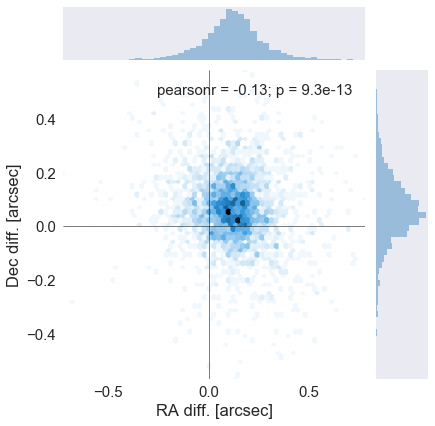

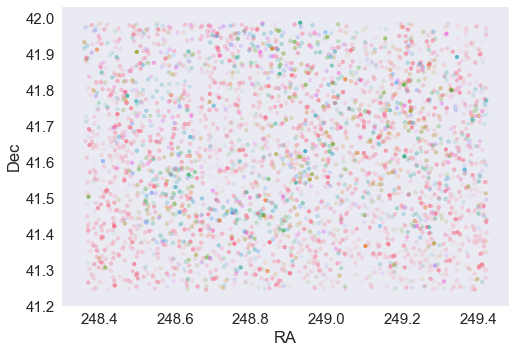

In [10]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [11]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.12127187875989875 arcsec
Dec correction: -0.05999340023805644 arcsec


In [12]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

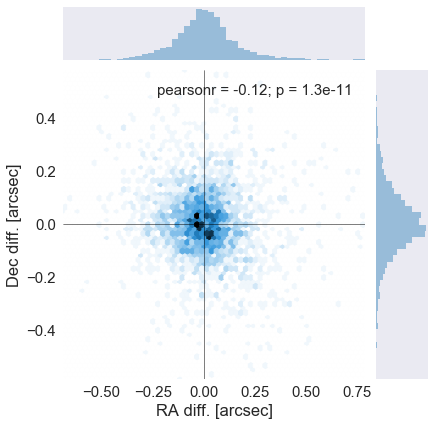

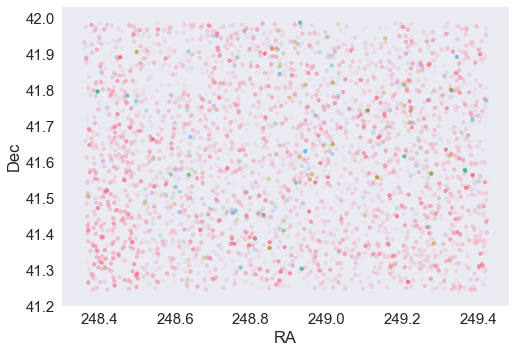

In [13]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [14]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [15]:
GAIA_FLAG_NAME = "wfc_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

4018 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [16]:
catalogue.write("{}/INT-WFC.fits".format(OUT_DIR), overwrite=True)